# Init

In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 17.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [2]:
from pathlib import Path

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import optuna.integration.lightgbm as optlgb
import joblib
import optuna as opt

from prettytable import PrettyTable

from sklearn.model_selection import (
    train_test_split,
    validation_curve,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
)
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, PowerTransformer, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import log_loss, classification_report, ConfusionMatrixDisplay
from sklearn.base import TransformerMixin, ClassNamePrefixFeaturesOutMixin, BaseEstimator, check_is_fitted, check_X_y
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.decomposition import PCA

rng = np.random.RandomState(1234567890)

In [3]:
data_p = Path("/content/drive/MyDrive/Colab Notebooks/2023/S03E26_PlayCirrhosis/Data")
train, test = pd.read_csv(data_p / "train.csv.gz"), pd.read_csv(data_p / "test.csv.gz")
train = train.rename(columns=lambda x: x.lower().strip())
test = test.rename(columns=lambda x: x.lower().strip())

le = LabelEncoder()
train["le_status"] = le.fit_transform(train["status"])

X_train, X_val, y_train, y_val = train_test_split(train.drop(columns=["id", "status", "le_status"]), train["le_status"], test_size=0.2, stratify=train["status"], random_state=rng)
X_train.shape, X_val.shape

((6324, 18), (1581, 18))

In [4]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1581 entries, 6751 to 3247
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   n_days         1581 non-null   int64  
 1   drug           1581 non-null   object 
 2   age            1581 non-null   int64  
 3   sex            1581 non-null   object 
 4   ascites        1581 non-null   object 
 5   hepatomegaly   1581 non-null   object 
 6   spiders        1581 non-null   object 
 7   edema          1581 non-null   object 
 8   bilirubin      1581 non-null   float64
 9   cholesterol    1581 non-null   float64
 10  albumin        1581 non-null   float64
 11  copper         1581 non-null   float64
 12  alk_phos       1581 non-null   float64
 13  sgot           1581 non-null   float64
 14  tryglicerides  1581 non-null   float64
 15  platelets      1581 non-null   float64
 16  prothrombin    1581 non-null   float64
 17  stage          1581 non-null   float64
dtypes: fl

In [5]:
cat_cols = X_train.select_dtypes(include=object).columns.tolist() + ["stage"]

# Modelling

## Base (no feature engineering)

In [6]:
ord_trx = ColumnTransformer([("", OrdinalEncoder(), cat_cols)], remainder="passthrough")
ord_trx.set_output(transform="pandas")

base_xgb = Pipeline([
    ("ordinal_encoder", ord_trx), ("xgb", xgb.sklearn.XGBClassifier())
]).fit(X_train, y_train)
base_xgb_ypred = base_xgb.predict_proba(X_val)
log_loss(y_train, base_xgb.predict_proba(X_train)), log_loss(y_val, base_xgb_ypred)

(0.06793282401210068, 0.502595480774506)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

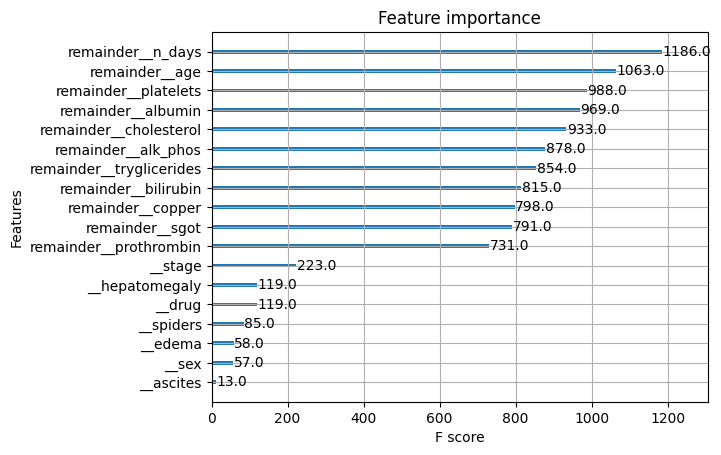

In [7]:
xgb.plot_importance(base_xgb[-1])

In [8]:
print(classification_report(y_val, np.argmax(base_xgb_ypred, axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       993
           1       0.64      0.25      0.36        55
           2       0.76      0.74      0.75       533

    accuracy                           0.82      1581
   macro avg       0.75      0.63      0.66      1581
weighted avg       0.81      0.82      0.81      1581



## Base + Multiclass WoE categorical

In [9]:
def feateng(df):
    threshold_platelets = 150
    df['thrombocytopenia'] = np.where(df['platelets'] < threshold_platelets, 1, 0)

    threshold_alk_phos = (44, 147)
    df['elevated_alk_phos'] = np.where((df['alk_phos'] > threshold_alk_phos[1]) | (df['alk_phos'] < threshold_alk_phos[0]), 1, 0)

    normal_copper_range = (62, 140)
    df['normal_copper'] = np.where((df['copper'] >= normal_copper_range[0]) & (df['copper'] <= normal_copper_range[1]), 1, 0)

    normal_albumin_range = (3.4, 5.4)
    df['normal_albumin'] = np.where((df['albumin'] >= normal_albumin_range[0]) & (df['albumin'] <= normal_albumin_range[1]), 1, 0)

    normal_bilirubin_range = (0.2, 1.2)
    df['normal_bilirubin'] = np.where((df['bilirubin'] >= normal_bilirubin_range[0]) & (df['bilirubin'] <= normal_bilirubin_range[1]), 1, 0)

    df["cholesterol_risk"] = pd.cut(df["cholesterol"], [0, 200, 240, 9999], labels=["normal", "borderline", "high"])
    df["tryglicerides_risk"] = pd.cut(df["tryglicerides"], [0, 150, 200, 500, 9999], labels=["normal", "moderate", "high", "very_high"])

    return df

class MulticlassWOETransformer(BaseEstimator, TransformerMixin, ClassNamePrefixFeaturesOutMixin):
    def __init__(self, eps: float = 0.001):
        self.woe_mapping_ = {}
        self.eps = eps

    def __sklearn_clone__(self):
        return self

    def fit(self, X, y=None):
        def logodds(x):
            if not len(x):
                return 0
            event_dist = sum(x) / len(x)
            non_event_dist = sum(x == 0) / len(x)

            return np.log((event_dist + self.eps) / (non_event_dist + self.eps))
        # check_X_y(X, y, accept_sparse=False)

        yy = y.copy(deep=True)
        del y

        yy = yy.to_frame("target")
        for i in yy["target"].unique():
            yy[f"target_{i}"] = np.where(yy["target"] == i, 1, 0)
        Xy = pd.concat([X, yy.drop(columns=["target"])], axis=1)
        self.feature_names_in_ = X.columns.tolist()
        self.n_features_ = X.shape[1]

        for c in self.feature_names_in_:
            for t in yy.drop(columns=["target"]).columns:
                self.woe_mapping_[c + "_" + t.split("_")[1]] = Xy.groupby(c)[t].apply(logodds).to_dict()

        self._n_features_out = len(self.woe_mapping_)
        self.is_fitted_ = True

        return self

    def transform(self, X):
        check_is_fitted(self, "is_fitted_")
        if X.shape[1] != self.n_features_:
            raise ValueError('Shape of input is different from what was seen'
                             'in `fit`')

        X = X.assign(**{c: X["_".join(c.split("_")[:-1])].map(v) for c, v in self.woe_mapping_.items()})

        return X[list(self.woe_mapping_.keys())].values

    def get_feature_names_out(self, input_features=None):
        return [c for c in self.woe_mapping_]

In [89]:
X_train, X_val, test_out = feateng(X_train), feateng(X_val), feateng(test)

cat_cols += ["thrombocytopenia", "elevated_alk_phos", "normal_copper", "normal_albumin", "normal_bilirubin", "cholesterol_risk", "tryglicerides_risk"]

In [11]:
ord_trx = ColumnTransformer([("", OrdinalEncoder(), cat_cols)], remainder="passthrough", verbose_feature_names_out=False)
ord_trx.set_output(transform="pandas")

woe_trx = ColumnTransformer([("", MulticlassWOETransformer(), cat_cols)], remainder="passthrough", verbose_feature_names_out=False)
woe_trx.set_output(transform="pandas")

fteng1_xgb = Pipeline([
    ("ordinal_encoder", ord_trx),
    ("woe_encoder", woe_trx),
    ("xgb", xgb.sklearn.XGBClassifier())
]).fit(X_train, y_train)
fteng1_xgb_ypred = fteng1_xgb.predict_proba(X_val)
log_loss(y_train, fteng1_xgb.predict_proba(X_train)), log_loss(y_val, fteng1_xgb_ypred)

(0.06385646365355903, 0.5100881957759915)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

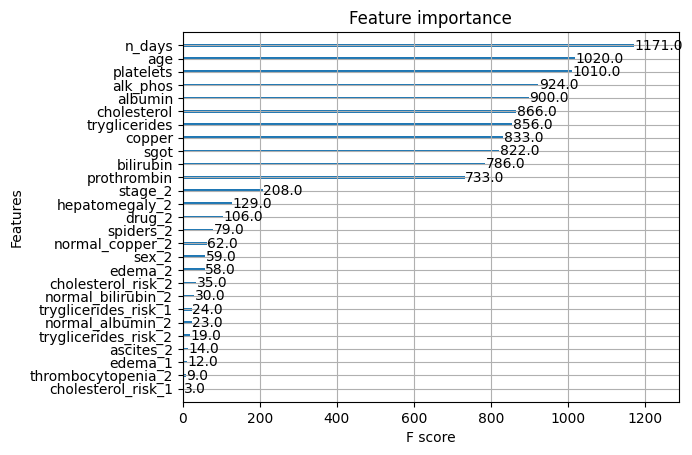

In [12]:
xgb.plot_importance(fteng1_xgb[-1])

In [13]:
print(classification_report(y_val, np.argmax(fteng1_xgb_ypred, axis=1)))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       993
           1       0.68      0.24      0.35        55
           2       0.77      0.74      0.75       533

    accuracy                           0.82      1581
   macro avg       0.77      0.62      0.66      1581
weighted avg       0.82      0.82      0.81      1581



### Plot validation curve

In [14]:
cv = StratifiedKFold(n_splits=5)

In [15]:
def plot_validation_curve(train_loss: np.array, val_loss: np.array, x_vals, xlab: str = "", ylab: str = "", ax = None):
    train_mean, val_mean = np.mean(train_loss, axis=1), np.mean(val_loss, axis=1)
    train_std, val_std = np.std(train_loss, axis=1), np.std(val_loss, axis=1)

    if not ax:
        fig, ax = plt.subplots()

    ax.plot(x_vals, train_mean, marker="o", label="Train")
    ax.fill_between(x_vals, train_mean+train_std, train_mean-train_std, alpha=.2)
    ax.plot(x_vals, val_mean, marker="*", label="Val")
    ax.fill_between(x_vals, val_mean+val_std, val_mean-val_std, alpha=.2)
    plt.legend()

    if xlab:
        ax.set_xlabel(xlab)
    if ylab:
        ax.set_ylabel(ylab)

    return ax

def plot_validation_curve_noproc(train_mean: np.array, train_std: np.array, val_mean: np.array, val_std: np.array, x_vals, xlab: str = "", ylab: str = "", ax = None):
    if not ax:
        fig, ax = plt.subplots()

    ax.plot(x_vals, train_mean, marker="o", label="Train")
    ax.fill_between(x_vals, train_mean+train_std, train_mean-train_std, alpha=.2)
    ax.plot(x_vals, val_mean, marker="*", label="Val")
    ax.fill_between(x_vals, val_mean+val_std, val_mean-val_std, alpha=.2)
    plt.legend()

    if xlab:
        ax.set_xlabel(xlab)
    if ylab:
        ax.set_ylabel(ylab)

    return ax

def proc_xgbcv_res(dmat_res: list):
    train_loss, val_loss, best_iter = [], [], []
    train_std, val_std = [], []

    for dfw in dmat_res:
        best = dfw.nsmallest(1, "test-mlogloss-mean")
        train_loss.append(best["train-mlogloss-mean"].values[0])
        train_std.append(best["train-mlogloss-std"].values[0])
        val_loss.append(best["test-mlogloss-mean"].values[0])
        val_std.append(best["test-mlogloss-std"].values[0])
        best_iter.append(best.index.values[0])

    return np.array(train_loss), np.array(val_loss), np.array(train_std), np.array(val_std), best_iter

#### GridSearchCV

In [16]:
if (data_p / "gridsearch_1.pkz").exists():
    gcv = joblib.load(data_p / "gridsearch_1.pkz")
else:
    xgb_params = {
        "objective": "multi:softprob",
        "learning_rate": 0.3,
        "verbosity": 0,
        "booster": "gbtree",
        "tree_method": "hist",
        "device": "cuda"
    }
    gcv_xgb_pipe = Pipeline([
        ("ordinal_encoder", ord_trx),
        ("woe_encoder", woe_trx),
        ("xgb", xgb.sklearn.XGBClassifier(**xgb_params))
    ])
    param_grid = {
        "xgb__max_depth": range(2, 7, 1),
        "xgb__grow_policy": ["depthwise", "lossguide"],
        "xgb__n_estimators": range(30, 201, 10)
    }

    gcv = GridSearchCV(
        gcv_xgb_pipe,
        param_grid,
        scoring="neg_log_loss",
        refit=False,
        cv=cv,
        verbose=0,
        error_score="raise",
        return_train_score=True,
        n_jobs=2
    )
    gcv.fit(X_train, y_train)

    joblib.dump(gcv, data_p / "gridsearch_1.pkz", compress=9)
gcv_res = pd.DataFrame(gcv.cv_results_).sort_values("rank_test_score")

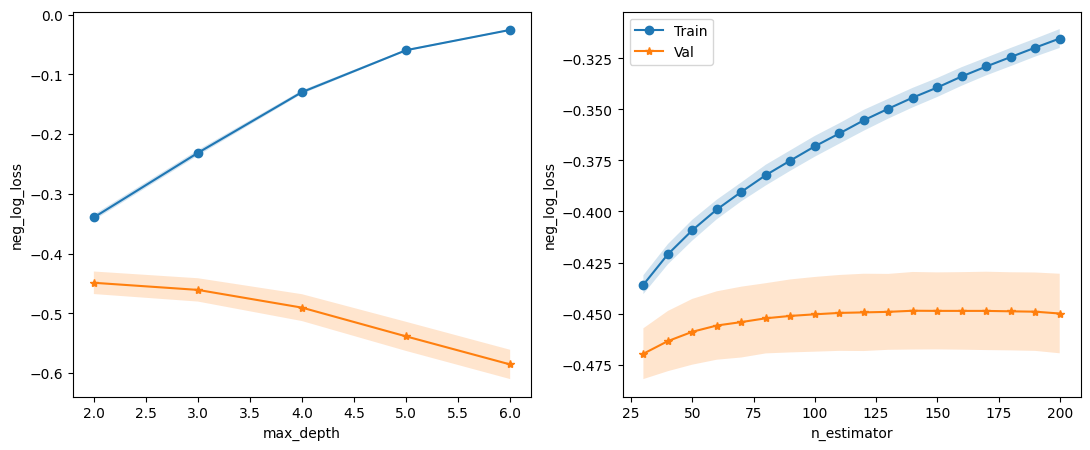

In [17]:
max_depth_loss = gcv_res.query("param_xgb__n_estimators == 150 and param_xgb__grow_policy == 'lossguide'")[["param_xgb__max_depth", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]].sort_values("param_xgb__max_depth")
n_est_loss = gcv_res.query("param_xgb__max_depth == 2 and param_xgb__grow_policy == 'lossguide'")[["param_xgb__n_estimators", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]].sort_values("param_xgb__n_estimators")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[13, 5])
ax1 = plot_validation_curve_noproc(max_depth_loss["mean_train_score"], max_depth_loss["std_train_score"], max_depth_loss["mean_test_score"], max_depth_loss["std_test_score"], max_depth_loss["param_xgb__max_depth"].astype(int).values, xlab="max_depth", ylab="neg_log_loss", ax=ax1)
ax2 = plot_validation_curve_noproc(n_est_loss["mean_train_score"], n_est_loss["std_train_score"], n_est_loss["mean_test_score"], n_est_loss["std_test_score"], n_est_loss["param_xgb__n_estimators"].astype(int).values, xlab="n_estimator", ylab="neg_log_loss", ax=ax2)

In [18]:
if (data_p / "gridsearch_2.pkz").exists():
    gcv = joblib.load(data_p / "gridsearch_2.pkz")
else:
    xgb_params = {
        "objective": "multi:softprob",
        "learning_rate": 0.3,
        "verbosity": 0,
        "booster": "gbtree",
        "tree_method": "hist",
        "device": "cuda",
        "max_depth": 2,
        "grow_policy": "depthwise",
        "n_estimator": 140
    }
    gcv_xgb_pipe = Pipeline([
        ("ordinal_encoder", ord_trx),
        ("woe_encoder", woe_trx),
        ("xgb", xgb.sklearn.XGBClassifier(**xgb_params))
    ])
    param_grid = {
        "xgb__reg_alpha": range(0, 11, 1),
        "xgb__reg_lambda": range(0, 11, 1)
    }

    gcv = GridSearchCV(
        gcv_xgb_pipe,
        param_grid,
        scoring="neg_log_loss",
        refit=False,
        cv=cv,
        verbose=0,
        error_score="raise",
        return_train_score=True,
        n_jobs=2
    )
    gcv.fit(X_train, y_train)

    joblib.dump(gcv, data_p / "gridsearch_2.pkz", compress=9)
gcv_res = pd.DataFrame(gcv.cv_results_).sort_values("rank_test_score")

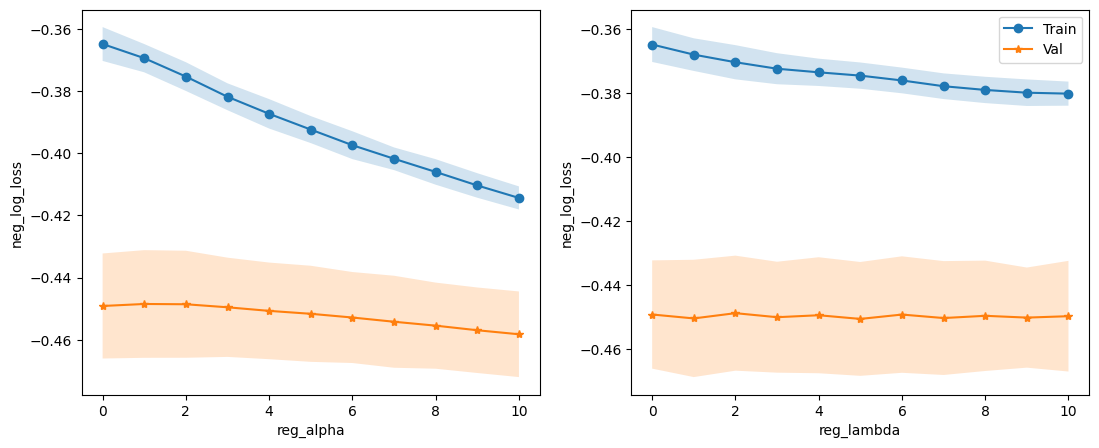

In [19]:
reg_alpha_loss = gcv_res.query("param_xgb__reg_lambda == 0")[["param_xgb__reg_alpha", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]].sort_values("param_xgb__reg_alpha")
reg_lambda_loss = gcv_res.query("param_xgb__reg_alpha == 0")[["param_xgb__reg_lambda", "mean_train_score", "std_train_score", "mean_test_score", "std_test_score"]].sort_values("param_xgb__reg_lambda")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[13, 5])
ax1 = plot_validation_curve_noproc(reg_alpha_loss["mean_train_score"], reg_alpha_loss["std_train_score"], reg_alpha_loss["mean_test_score"], reg_alpha_loss["std_test_score"], reg_alpha_loss["param_xgb__reg_alpha"].astype(int).values, xlab="reg_alpha", ylab="neg_log_loss", ax=ax1)
ax2 = plot_validation_curve_noproc(reg_lambda_loss["mean_train_score"], reg_lambda_loss["std_train_score"], reg_lambda_loss["mean_test_score"], reg_lambda_loss["std_test_score"], reg_lambda_loss["param_xgb__reg_lambda"].astype(int).values, xlab="reg_lambda", ylab="neg_log_loss", ax=ax2)

# Hyperparameter optimisation

In [20]:
drop_trx = ColumnTransformer([("", "drop", [
    # trial 1
    'drug_1',
    'sex_0',
    'ascites_2',
    'ascites_1',
    'spiders_1',
    'stage_1',
    'thrombocytopenia_2',
    'thrombocytopenia_0',
    'thrombocytopenia_1',
    'elevated_alk_phos_2',
    'elevated_alk_phos_0',
    'elevated_alk_phos_1',
    'normal_copper_1',
    'normal_albumin_2',
    'normal_albumin_0',
    'normal_albumin_1',
    'normal_bilirubin_0',
    'normal_bilirubin_1',
    'cholesterol_risk_2',
    'cholesterol_risk_0',
    'cholesterol_risk_1',
    'tryglicerides_risk_2',
    'tryglicerides_risk_0',
    'tryglicerides_risk_1'
])], verbose_feature_names_out=False, remainder="passthrough")
drop_trx.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('', 'drop',
                                 ['drug_1', 'sex_0', 'ascites_2', 'ascites_1',
                                  'spiders_1', 'stage_1', 'thrombocytopenia_2',
                                  'thrombocytopenia_0', 'thrombocytopenia_1',
                                  'elevated_alk_phos_2', 'elevated_alk_phos_0',
                                  'elevated_alk_phos_1', 'normal_copper_1',
                                  'normal_albumin_2', 'normal_albumin_0',
                                  'normal_albumin_1', 'normal_bilirubin_0',
                                  'normal_bilirubin_1', 'cholesterol_risk_2',
                                  'cholesterol_risk_0', 'cholesterol_risk_1',
                                  'tryglicerides_risk_2',
                                  'tryglicerides_risk_0',
                                  'tryglicerides_risk_1'])],
                  verbose_feature_names_out=False)

## XGB Trial 1

In [21]:
def objective(trial):
    xgb_params = {
        "objective": "multi:softprob",
        "verbosity": 0,
        "booster": "gbtree",
        "tree_method": "hist",
        "device": "cuda",
        "grow_policy": "depthwise",
        "sampling_method": "gradient_based",
        "n_estimator": trial.suggest_int("n_estimator", 100, 200, step=5),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 4, step=1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 2.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        # "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step=1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    opt_xgb_pipe = Pipeline([
        ("ordinal_encoder", ord_trx),
        ("woe_encoder", woe_trx),
        ("xgb", xgb.sklearn.XGBClassifier(**xgb_params))
    ])

    res = cross_val_score(opt_xgb_pipe, X_train, y_train, scoring="neg_log_loss", cv=5, n_jobs=-1, error_score="raise")

    return np.mean(res) - np.std(res)

In [22]:
if (data_p / "optuna_xgb.pkz").exists():
    study = joblib.load(data_p / "optuna_xgb.pkz")
else:
    study = opt.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=1800)
    joblib.dump(study, data_p / "optuna_xgb.pkz", compress=9)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: -0.46032109022321815
  Params: 
    n_estimator: 105
    learning_rate: 0.20488584219845082
    max_depth: 3
    reg_alpha: 6.075625645401835e-06
    reg_lambda: 0.0067281459166902546
    min_child_weight: 9
    subsample: 0.7076380573798365
    colsample_bytree: 0.619797761484852


In [23]:
if (data_p / "trial1_xgb.pkz").exists():
    optimised_xgb_pipe = joblib.load(data_p / "trial1_xgb.pkz")
else:
    xgb_params = {
        "objective": "multi:softprob",
        "verbosity": 0,
        "booster": "gbtree",
        "tree_method": "hist",
        "device": "cuda",
        "grow_policy": "depthwise",
        "sampling_method": "gradient_based",
        "importance_type": "total_gain"
    }
    xgb_params.update(study.best_params)
    optimised_xgb_pipe = Pipeline([
        ("ordinal_encoder", ord_trx),
        ("woe_encoder", woe_trx),
        ("xgb", xgb.sklearn.XGBClassifier(**xgb_params))
    ]).fit(X_train, y_train)

    joblib.dump(optimised_xgb_pipe, data_p / "trial1_xgb.pkz", compress=9)

log_loss(y_val, optimised_xgb_pipe.predict_proba(X_val))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:57:02] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:57:02] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.4468453995300138

In [24]:
tmp_pipe = Pipeline([
    ("ordinal_encoder", ord_trx),
    ("woe_encoder", woe_trx)
]).fit_transform(X_train, y_train)
[c for c, _ in filter(lambda x: x[1] < 0.001, zip(tmp_pipe.columns, optimised_xgb_pipe[-1].feature_importances_))]

['drug_1',
 'sex_0',
 'ascites_2',
 'ascites_1',
 'spiders_1',
 'stage_1',
 'thrombocytopenia_2',
 'thrombocytopenia_0',
 'thrombocytopenia_1',
 'elevated_alk_phos_2',
 'elevated_alk_phos_0',
 'elevated_alk_phos_1',
 'normal_copper_1',
 'normal_albumin_2',
 'normal_albumin_0',
 'normal_albumin_1',
 'normal_bilirubin_0',
 'normal_bilirubin_1',
 'cholesterol_risk_2',
 'cholesterol_risk_0',
 'cholesterol_risk_1',
 'tryglicerides_risk_2',
 'tryglicerides_risk_0',
 'tryglicerides_risk_1']

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

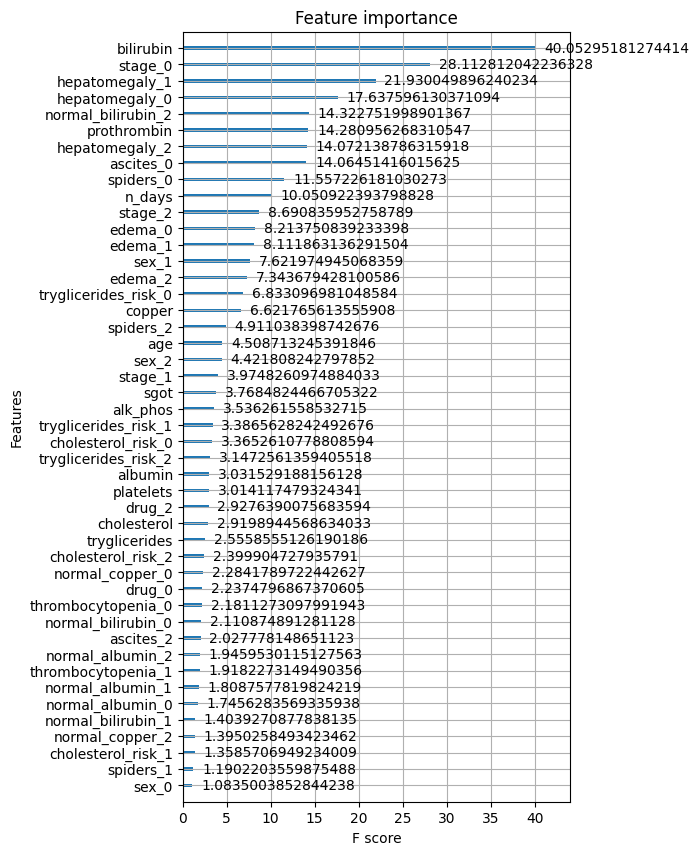

In [25]:
fig, ax = plt.subplots(1, 1, figsize=[5, 10])
xgb.plot_importance(optimised_xgb_pipe[-1], ax=ax, importance_type="gain")

## XGB Trial 2

In [26]:
def objective(trial):
    xgb_params = {
        "objective": "multi:softprob",
        "verbosity": 0,
        "booster": "gbtree",
        "tree_method": "hist",
        "device": "cuda",
        "grow_policy": "depthwise",
        "sampling_method": "gradient_based",
        "n_estimator": 140,
        "learning_rate": 0.2,
        "max_depth": trial.suggest_int("max_depth", 2, 4, step=1),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 2.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10, step=1),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
    }
    opt_xgb_pipe = Pipeline([
        ("ordinal_encoder", ord_trx),
        ("woe_encoder", woe_trx),
        ("drop_cols", drop_trx),
        ("xgb", xgb.sklearn.XGBClassifier(**xgb_params))
    ])

    res = cross_val_score(opt_xgb_pipe, X_train, y_train, scoring="neg_log_loss", cv=5, n_jobs=-1, error_score="raise")

    return np.mean(res) - np.std(res)

In [27]:
if (data_p / "optuna_xgb.2.pkz").exists():
    study = joblib.load(data_p / "optuna_xgb.2.pkz")
else:
    study = opt.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=1800)
    joblib.dump(study, data_p / "optuna_xgb.2.pkz", compress=9)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  100
Best trial:
  Value: -0.4621726328973429
  Params: 
    max_depth: 3
    reg_alpha: 6.898274609547968e-05
    reg_lambda: 1.5949555437571746e-05
    gamma: 0.047963467405079396
    min_child_weight: 9
    subsample: 0.9875359131908601
    colsample_bytree: 0.5627506573729599


In [28]:
if (data_p / "final_xgb.pkz").exists():
    optimised_xgb_pipe = joblib.load(data_p / "final_xgb.pkz")
else:
    xgb_params = {
        "objective": "multi:softprob",
        "verbosity": 0,
        "booster": "gbtree",
        "tree_method": "hist",
        "device": "cuda",
        "grow_policy": "depthwise",
        "sampling_method": "gradient_based",
        "importance_type": "total_gain"
    }
    xgb_params.update(study.best_params)
    optimised_xgb_pipe = Pipeline([
        ("ordinal_encoder", ord_trx),
        ("woe_encoder", woe_trx),
        ("drop_cols", drop_trx),
        ("xgb", xgb.sklearn.XGBClassifier(**xgb_params))
    ]).fit(X_train, y_train)

    joblib.dump(optimised_xgb_pipe, data_p / "final_xgb.pkz", compress=9)

log_loss(y_val, optimised_xgb_pipe.predict_proba(X_val))

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:57:06] WARNING: /workspace/src/gbm/gbtree.cc:385: Changing updater from `grow_gpu_hist` to `grow_quantile_histmaker`.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [10:57:06] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


0.4450623937914124

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

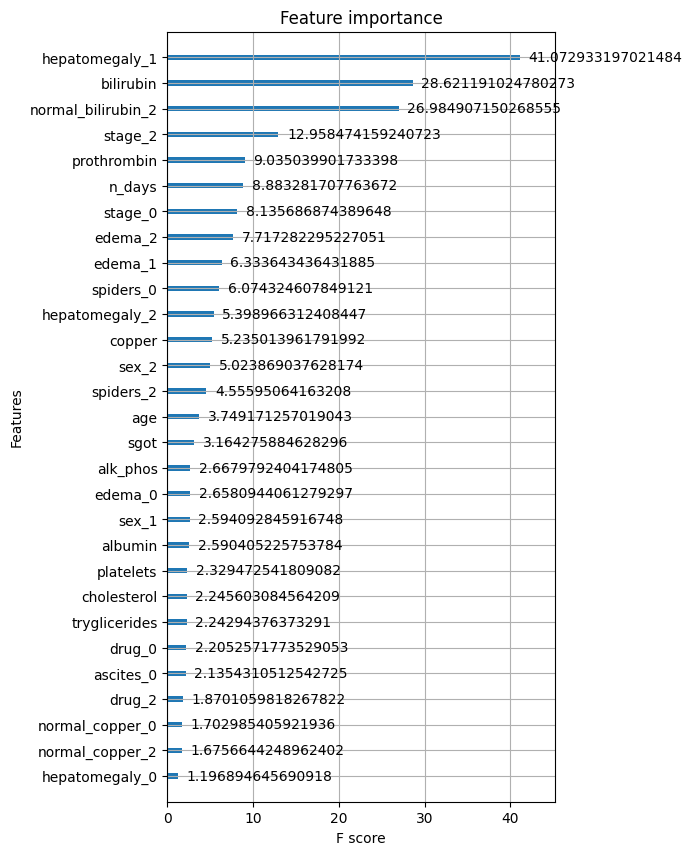

In [29]:
fig, ax = plt.subplots(1, 1, figsize=[5, 10])
xgb.plot_importance(optimised_xgb_pipe[-1], ax=ax, importance_type="gain")

In [30]:
print(classification_report(y_val, optimised_xgb_pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       993
           1       0.61      0.25      0.36        55
           2       0.78      0.73      0.75       533

    accuracy                           0.82      1581
   macro avg       0.75      0.63      0.66      1581
weighted avg       0.82      0.82      0.82      1581



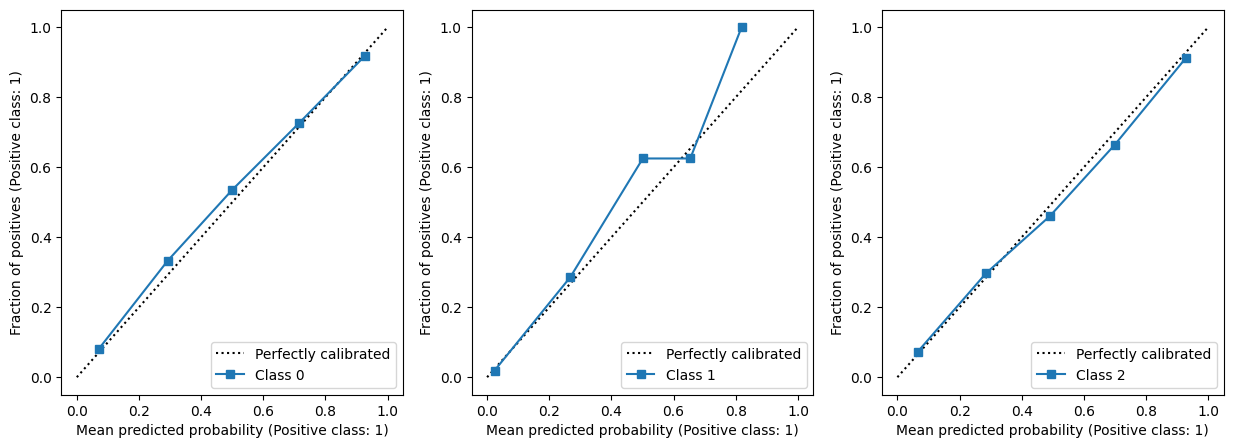

In [31]:
y_val_pred = optimised_xgb_pipe.predict_proba(X_val)

fig, ax = plt.subplots(1, 3, figsize=[15, 5])
for i in range(0, 3):
    CalibrationDisplay.from_predictions(y_val.map({0: int(i == 0), 1: int(i == 1), 2: int(i == 2)}), y_val_pred[:, i], name=f"Class {i}", ax=ax[i])

### Optimise Class Weight

<Axes: xlabel='class_1_weight', ylabel='log loss'>

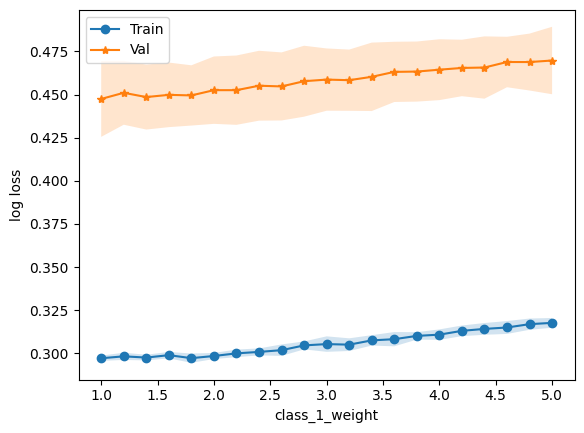

In [32]:
class_1_range = np.linspace(1, 5, 21)
if (data_p / "xgb_class_weights.pkz").exists():
    train_loss, val_loss = joblib.load(data_p / "xgb_class_weights.pkz")
else:
    train_loss, val_loss = [], []
    class_weight = {0: 1, 1: 1, 2: 1}

    xgb_params = {
        "objective": "multi:softprob",
        "verbosity": 0,
        "booster": "gbtree",
        "tree_method": "hist",
        "device": "cuda",
        "grow_policy": "depthwise",
        "sampling_method": "gradient_based",
        "importance_type": "total_gain"
    }
    xgb_params.update(study.best_params)
    optimised_xgb_pipe = Pipeline([
        ("ordinal_encoder", ord_trx),
        ("woe_encoder", woe_trx),
        ("drop_cols", drop_trx),
        ("xgb", xgb.sklearn.XGBClassifier(**xgb_params))
    ])

    for i in class_1_range:
        class_weight[1] = i
        tls, vls = [], []
        for train_idx, val_idx in cv.split(X_train, y_train):
            sample_weight = y_train.iloc[train_idx].map(class_weight)
            optimised_xgb_pipe.fit(X_train.iloc[train_idx], y_train.iloc[train_idx], xgb__sample_weight=sample_weight)

            tls.append(log_loss(y_train.iloc[train_idx], optimised_xgb_pipe.predict_proba(X_train.iloc[train_idx])))
            vls.append(log_loss(y_train.iloc[val_idx], optimised_xgb_pipe.predict_proba(X_train.iloc[val_idx])))

        train_loss.append(tls)
        val_loss.append(vls)

    joblib.dump((train_loss, val_loss), data_p / "xgb_class_weights.pkz", compress=9)

plot_validation_curve(train_loss, val_loss, class_1_range, xlab="class_1_weight", ylab="log loss")

## LightGBM

In [33]:
base_lgb = Pipeline([
    ("ordinal_encoder", ord_trx),
    ("woe_encoder", woe_trx),
    ("lgb", lgb.LGBMClassifier(importance_type="gain", verbose=0))
]).fit(X_train, y_train)

log_loss(y_val, base_lgb.predict_proba(X_val))

0.4626420490271185

In [34]:
print(classification_report(y_val, base_lgb.predict(X_val)))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87       993
           1       0.68      0.24      0.35        55
           2       0.77      0.72      0.74       533

    accuracy                           0.82      1581
   macro avg       0.76      0.62      0.65      1581
weighted avg       0.81      0.82      0.81      1581



<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

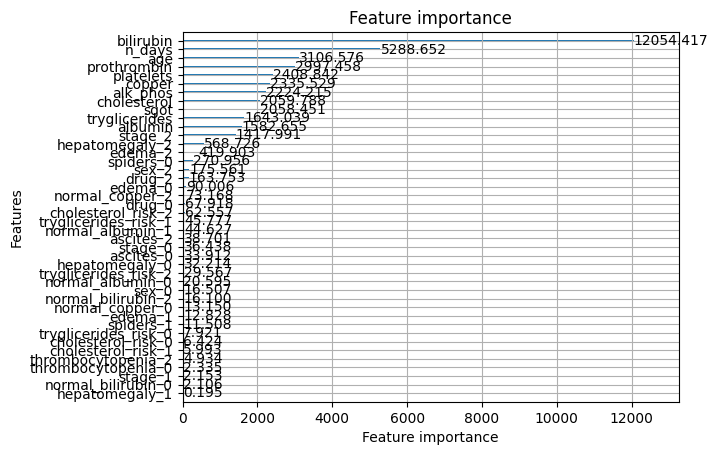

In [35]:
lgb.plot_importance(base_lgb[-1], importance_type="gain")

In [36]:
param_grid = {
    "lgb__n_estimators": range(100, 201, 20),
    "lgb__learning_rate": [1e-4, 1e-3, 1e-2, 1e-1],
    "lgb__boosting_type": ["gbdt", "dart"]
}
if (data_p / "lgb_gcv.1.pkz").exists():
    lgb_gcv = joblib.load(data_p / "lgb_gcv.1.pkz")
else:
    lgb_params = {"verbose": 0, "objective": "multiclass", "importance_type": "gain"}

    lgb_pipe = Pipeline([
        ("ordinal_encoder", ord_trx),
        ("woe_encoder", woe_trx),
        ("lgb", lgb.LGBMClassifier(**lgb_params))
    ])
    lgb_gcv = GridSearchCV(
        lgb_pipe, param_grid,
        scoring="neg_log_loss",
        n_jobs=1,
        refit=False,
        cv=cv,
        verbose=0,
        error_score="raise",
        return_train_score=True
    ).fit(X_train, y_train)

    joblib.dump(lgb_gcv, data_p / "lgb_gcv.1.pkz", compress=9)

gcv_res = pd.DataFrame(lgb_gcv.cv_results_).sort_values("rank_test_score")

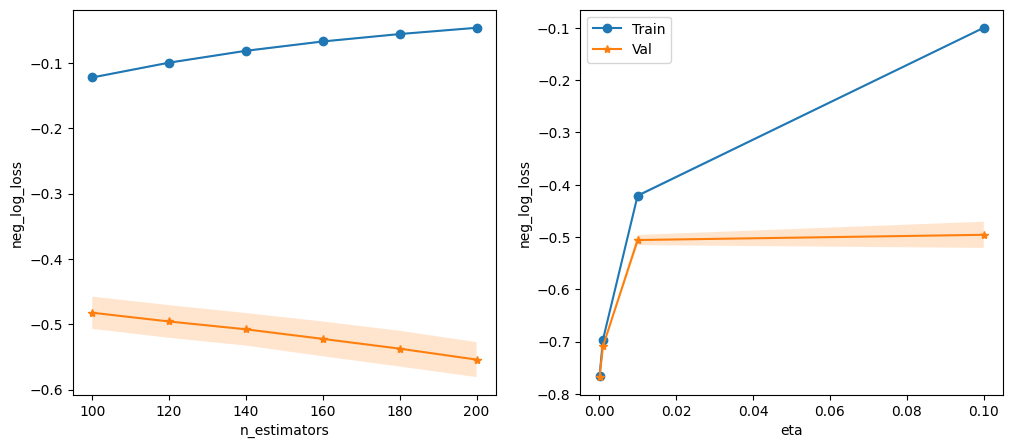

In [37]:
gbdt_n_est = gcv_res.query("param_lgb__learning_rate == 0.1 and param_lgb__boosting_type == 'gbdt'").sort_values("param_lgb__n_estimators")
gbdt_eta = gcv_res.query("param_lgb__n_estimators == 120 and param_lgb__boosting_type == 'gbdt'").sort_values("param_lgb__learning_rate")

fig, ax = plt.subplots(1, 2, figsize=[12, 5])

ax1 = plot_validation_curve_noproc(gbdt_n_est["mean_train_score"], gbdt_n_est["std_train_score"], gbdt_n_est["mean_test_score"], gbdt_n_est["std_test_score"], param_grid["lgb__n_estimators"], xlab="n_estimators", ylab="neg_log_loss", ax=ax[0])
ax2 = plot_validation_curve_noproc(gbdt_eta["mean_train_score"], gbdt_eta["std_train_score"], gbdt_eta["mean_test_score"], gbdt_eta["std_test_score"], param_grid["lgb__learning_rate"], xlab="eta", ylab="neg_log_loss", ax=ax[1])

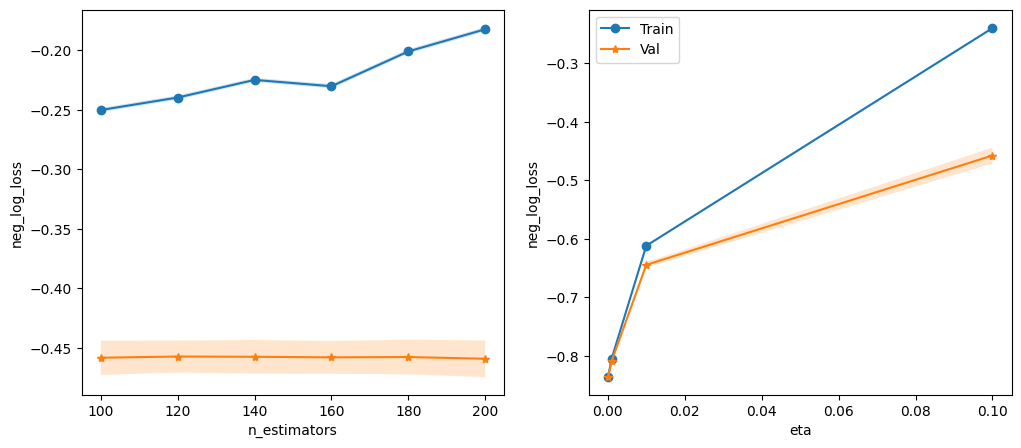

In [38]:
dart_n_est = gcv_res.query("param_lgb__learning_rate == 0.1 and param_lgb__boosting_type == 'dart'").sort_values("param_lgb__n_estimators")
dart_eta = gcv_res.query("param_lgb__n_estimators == 120 and param_lgb__boosting_type == 'dart'").sort_values("param_lgb__learning_rate")

fig, ax = plt.subplots(1, 2, figsize=[12, 5])

ax1 = plot_validation_curve_noproc(dart_n_est["mean_train_score"], dart_n_est["std_train_score"], dart_n_est["mean_test_score"], dart_n_est["std_test_score"], param_grid["lgb__n_estimators"], xlab="n_estimators", ylab="neg_log_loss", ax=ax[0])
ax2 = plot_validation_curve_noproc(dart_eta["mean_train_score"], dart_eta["std_train_score"], dart_eta["mean_test_score"], dart_eta["std_test_score"], param_grid["lgb__learning_rate"], xlab="eta", ylab="neg_log_loss", ax=ax[1])

In [39]:
param_grid = {
    "lgb__reg_alpha": np.linspace(0.0, 2.0, 11)
}
if (data_p / "lgb_gcv.2.pkz").exists():
    lgb_gcv = joblib.load(data_p / "lgb_gcv.2.pkz")
else:
    lgb_params = {
        "verbose": 0,
        "objective": "multiclass",
        "importance_type": "gain",
        "n_estimators": 120,
        "learning_rate": 0.1,
        "boosting_type": "dart"
    }

    lgb_pipe = Pipeline([
        ("ordinal_encoder", ord_trx),
        ("woe_encoder", woe_trx),
        ("lgb", lgb.LGBMClassifier(**lgb_params))
    ])
    lgb_gcv = GridSearchCV(
        lgb_pipe, param_grid,
        scoring="neg_log_loss",
        n_jobs=1,
        refit=False,
        cv=cv,
        verbose=0,
        error_score="raise",
        return_train_score=True
    ).fit(X_train, y_train)

    joblib.dump(lgb_gcv, data_p / "lgb_gcv.2.pkz", compress=9)

gcv_res = pd.DataFrame(lgb_gcv.cv_results_).sort_values("rank_test_score")

<Axes: xlabel='l1', ylabel='neg_log_loss'>

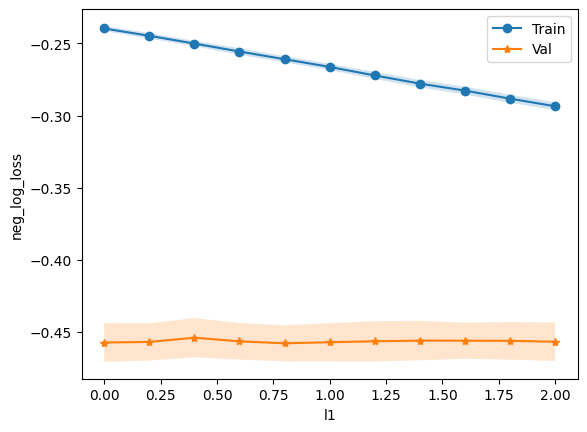

In [40]:
gcv_res = gcv_res.sort_values("param_lgb__reg_alpha")
plot_validation_curve_noproc(gcv_res["mean_train_score"], gcv_res["std_train_score"], gcv_res["mean_test_score"], gcv_res["std_test_score"], param_grid["lgb__reg_alpha"], xlab="l1", ylab="neg_log_loss")

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

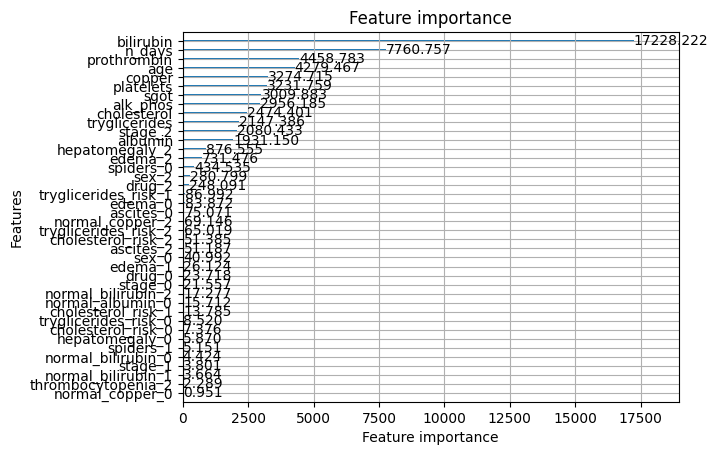

In [41]:
lgb_params = {
    "verbose": 0,
    "objective": "multiclass",
    "importance_type": "gain",
    "n_estimators": 120,
    "learning_rate": 0.1,
    "boosting_type": "dart",
    "reg_alpha": 0.4
}

lgb_pipe = Pipeline([
    ("ordinal_encoder", ord_trx),
    ("woe_encoder", woe_trx),
    ("lgb", lgb.LGBMClassifier(**lgb_params))
]).fit(X_train, y_train)

lgb.plot_importance(lgb_pipe[-1], importance_type="gain")

In [42]:
log_loss(y_val, lgb_pipe.predict_proba(X_val)), [c for c, _ in filter(lambda x: x[1] < 0.001, zip(tmp_pipe.columns, lgb_pipe[-1].feature_importances_ / sum(lgb_pipe[-1].feature_importances_)))]

(0.4518055836441161,
 ['drug_0',
  'drug_1',
  'sex_0',
  'sex_1',
  'ascites_2',
  'ascites_1',
  'hepatomegaly_0',
  'hepatomegaly_1',
  'spiders_2',
  'spiders_1',
  'edema_1',
  'stage_0',
  'stage_1',
  'thrombocytopenia_2',
  'thrombocytopenia_0',
  'thrombocytopenia_1',
  'elevated_alk_phos_2',
  'elevated_alk_phos_0',
  'elevated_alk_phos_1',
  'normal_copper_0',
  'normal_copper_1',
  'normal_albumin_2',
  'normal_albumin_0',
  'normal_albumin_1',
  'normal_bilirubin_2',
  'normal_bilirubin_0',
  'normal_bilirubin_1',
  'cholesterol_risk_2',
  'cholesterol_risk_0',
  'cholesterol_risk_1',
  'tryglicerides_risk_0'])

In [43]:
drop_trx = ColumnTransformer([("", "drop", ['drug_0',
  'drug_1',
  'sex_0',
  'sex_1',
  'ascites_2',
  'ascites_1',
  'hepatomegaly_0',
  'hepatomegaly_1',
  'spiders_2',
  'spiders_1',
  'edema_1',
  'stage_0',
  'stage_1',
  'thrombocytopenia_2',
  'thrombocytopenia_0',
  'thrombocytopenia_1',
  'elevated_alk_phos_2',
  'elevated_alk_phos_0',
  'elevated_alk_phos_1',
  'normal_copper_0',
  'normal_copper_1',
  'normal_albumin_2',
  'normal_albumin_0',
  'normal_albumin_1',
  'normal_bilirubin_2',
  'normal_bilirubin_0',
  'normal_bilirubin_1',
  'cholesterol_risk_2',
  'cholesterol_risk_0',
  'cholesterol_risk_1',
  'tryglicerides_risk_0'])], verbose_feature_names_out=False, remainder="passthrough")
drop_trx.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('', 'drop',
                                 ['drug_0', 'drug_1', 'sex_0', 'sex_1',
                                  'ascites_2', 'ascites_1', 'hepatomegaly_0',
                                  'hepatomegaly_1', 'spiders_2', 'spiders_1',
                                  'edema_1', 'stage_0', 'stage_1',
                                  'thrombocytopenia_2', 'thrombocytopenia_0',
                                  'thrombocytopenia_1', 'elevated_alk_phos_2',
                                  'elevated_alk_phos_0', 'elevated_alk_phos_1',
                                  'normal_copper_0', 'normal_copper_1',
                                  'normal_albumin_2', 'normal_albumin_0',
                                  'normal_albumin_1', 'normal_bilirubin_2',
                                  'normal_bilirubin_0', 'normal_bilirubin_1',
                                  'cholesterol_risk_2', 'cholesterol_risk_0',
                                  'cholesterol_risk_1', ...])],
                  verbose_feature_names_out=False)

In [44]:
lgb_params = {
    "verbose": 0,
    "objective": "multiclass",
    "importance_type": "gain",
    "n_estimators": 120,
    "learning_rate": 0.1,
    "boosting_type": "dart",
    "reg_alpha": 0.4
}

lgb_pipe = Pipeline([
    ("ordinal_encoder", ord_trx),
    ("woe_encoder", woe_trx),
    ("drop_cols", drop_trx),
    ("lgb", lgb.LGBMClassifier(**lgb_params))
]).fit(X_train, y_train)

log_loss(y_val, lgb_pipe.predict_proba(X_val))

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


0.44902597215872314

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

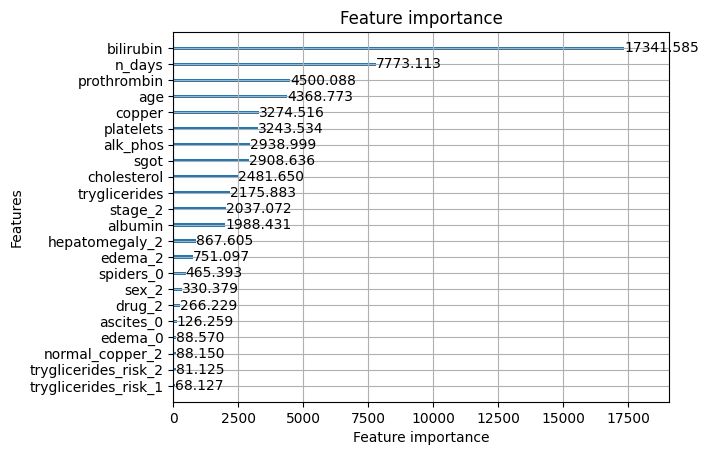

In [45]:
lgb.plot_importance(lgb_pipe[-1], importance_type="gain")

In [46]:
lgb_pipe = Pipeline([
    ("ordinal_encoder", ord_trx),
    ("woe_encoder", woe_trx),
    ("drop_cols", drop_trx)
]).fit(X_train, y_train)

if (data_p / "opt_lgb.1.pkz").exists():
    optimised_lgb = joblib.load(data_p / "opt_lgb.1.pkz")
else:
    dtrain, dval = optlgb.Dataset(lgb_pipe.transform(X_train), y_train), optlgb.Dataset(lgb_pipe.transform(X_val), y_val)
    lgb_params = {
        "verbose": 0,
        "objective": "multiclass",
        "boosting_type": "dart",
        "num_class": 3,
        "metric": "multi_logloss",
        "is_provide_training_metric": True
    }

    optimised_lgb = optlgb.train(lgb_params, dtrain, valid_sets=dval)

    joblib.dump(optimised_lgb, data_p / "opt_lgb.1.pkz", compress=9)

optimised_lgb.best_score

defaultdict(collections.OrderedDict,
            {'valid_0': OrderedDict([('multi_logloss', 0.43546364664285253)])})

In [47]:
final_lgb_pipe = Pipeline([
    ("ordinal_encoder", ord_trx),
    ("woe_encoder", woe_trx),
    ("drop_cols", drop_trx),
    ("lgb", lgb.LGBMClassifier(**optimised_lgb.params))
])

res = cross_val_score(final_lgb_pipe, X_train, y_train, cv=5, scoring="neg_log_loss", error_score="raise")

np.mean(res), np.std(res)

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=2.3572926954269433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3572926954269433e-06
[LightGBM] [Warning] lambda_l1 is set=1.7157443785642036e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7157443785642036e-05
[LightGBM] [Warning] bagging_fraction is set=0.6410056789680789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6410056789680789
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=2.3572926954269433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3572926954269433e-06
[LightGBM] [Warning] lambda_l1 is set=1.7157443785642036e-05, reg_alpha=

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=2.3572926954269433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3572926954269433e-06
[LightGBM] [Warning] lambda_l1 is set=1.7157443785642036e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7157443785642036e-05
[LightGBM] [Warning] bagging_fraction is set=0.6410056789680789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6410056789680789
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=2.3572926954269433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3572926954269433e-06
[LightGBM] [Warning] lambda_l1 is set=1.7157443785642036e-05, reg_alpha=

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=2.3572926954269433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3572926954269433e-06
[LightGBM] [Warning] lambda_l1 is set=1.7157443785642036e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7157443785642036e-05
[LightGBM] [Warning] bagging_fraction is set=0.6410056789680789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6410056789680789
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=2.3572926954269433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3572926954269433e-06
[LightGBM] [Warning] lambda_l1 is set=1.7157443785642036e-05, reg_alpha=

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=2.3572926954269433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3572926954269433e-06
[LightGBM] [Warning] lambda_l1 is set=1.7157443785642036e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7157443785642036e-05
[LightGBM] [Warning] bagging_fraction is set=0.6410056789680789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6410056789680789
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=2.3572926954269433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3572926954269433e-06
[LightGBM] [Warning] lambda_l1 is set=1.7157443785642036e-05, reg_alpha=

/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=2.3572926954269433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3572926954269433e-06
[LightGBM] [Warning] lambda_l1 is set=1.7157443785642036e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7157443785642036e-05
[LightGBM] [Warning] bagging_fraction is set=0.6410056789680789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6410056789680789
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.4, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4
[LightGBM] [Warning] lambda_l2 is set=2.3572926954269433e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3572926954269433e-06
[LightGBM] [Warning] lambda_l1 is set=1.7157443785642036e-05, reg_alpha=

(-0.44276136186582243, 0.020639488775406695)

In [48]:
if (data_p / "final_lgb.pkz").exists():
    final_lgb_pipe = joblib.load(data_p / "final_lgb.pkz")
else:
    final_lgb_pipe.fit(X_train, y_train)
    joblib.dump(final_lgb_pipe, data_p / "final_lgb.pkz", compress=9)

## SVC

In [49]:
num_cols = X_train.select_dtypes(include=np.number).columns[:-6]
numcat_trx = ColumnTransformer([
    ("p", PowerTransformer(standardize=True), num_cols),
    ("o", Pipeline([
        ("s1", OrdinalEncoder()),
        ("s2", MulticlassWOETransformer()),
        ("s3", PCA(n_components=0.95))
    ]), cat_cols)
], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

In [50]:
svc_pipe = Pipeline([
    ("numcat_encoder", numcat_trx),
    ("svc", SVC(probability=True, cache_size=2048, decision_function_shape="ovr", class_weight={0: 0.95, 1: 1.7, 2: 0.95}))
]).fit(X_train, y_train)
log_loss(y_val, svc_pipe.predict_proba(X_val))

0.5260825257713454

In [51]:
print(classification_report(y_val, svc_pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       993
           1       0.50      0.02      0.04        55
           2       0.75      0.68      0.71       533

    accuracy                           0.80      1581
   macro avg       0.69      0.54      0.54      1581
weighted avg       0.79      0.80      0.78      1581



In [52]:
def objective(trial):
    svc_params = {
        "probability": True,
        "cache_size": 2048,
        "decision_function_shape": "ovr",
        "kernel": trial.suggest_categorical("kernel", ["rbf", "poly"]),
        "class_weight": {
            0: 0.95,
            1: trial.suggest_float("class_1", 1.0, 3.0),
            2: 0.95
        },
        "C": trial.suggest_float("C", 1e-8, 1e8, log=True)
    }

    if svc_params["kernel"] == "poly":
        svc_params["degree"] = trial.suggest_int("degree", 2, 5, step=1)
        svc_params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
    elif svc_params["kernel"] == "rbf":
        svc_params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)

    numcat_trx = ColumnTransformer([
        ("p", PowerTransformer(standardize=True), num_cols),
        ("o", Pipeline([
            ("s1", OrdinalEncoder()),
            ("s2", MulticlassWOETransformer()),
            ("s3", PCA(n_components=0.95))
        ]), cat_cols)
    ], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

    svc_pipe = Pipeline([
        ("numcat_encoder", numcat_trx),
        ("svc", SVC(**svc_params))
    ])

    val_loss = []
    for train_idx, val_idx in cv.split(X_train, y_train):
        _ = svc_pipe.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        val_loss.append(log_loss(
            y_train.iloc[val_idx],
            svc_pipe.predict_proba(X_train.iloc[val_idx]),
            sample_weight=y_train.iloc[val_idx].map({0: 1, 1: 2, 2: 1})
        ))

    return -np.mean(val_loss) - np.std(val_loss)

if (data_p / "optuna_svc.pkz").exists():
    study = joblib.load(data_p / "optuna_svc.pkz")
else:
    study = opt.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=1800)
    joblib.dump(study, data_p / "optuna_svc.pkz", compress=9)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Number of finished trials:  10
Best trial:
  Value: -0.60601900914171
  Params: 
    kernel: rbf
    class_1: 2.130942668148142
    C: 1828505.8372321245
    gamma: 2.6034351697975405e-05


In [53]:
if (data_p / "final_svc.pkz").exists():
    logreg_pipe = joblib.load(data_p / "final_svc.pkz")
else:
    svc_params = {
        "probability": True,
        "cache_size": 2048,
        "decision_function_shape": "ovr",
        "kernel": "rbf",
        "gamma": 2.6034351697975405e-05,
        "class_weight": {
            0: 0.95,
            1: 2.130942668148142,
            2: 0.95
        },
        "C": 1828505.8372321245
    }

    numcat_trx = ColumnTransformer([
        ("p", PowerTransformer(standardize=True), num_cols),
        ("o", Pipeline([
            ("s1", OrdinalEncoder()),
            ("s2", MulticlassWOETransformer()),
            ("s3", PCA(n_components=0.95))
        ]), cat_cols)
    ], verbose_feature_names_out=False, remainder="passthrough").set_output(transform="pandas")

    svc_pipe = Pipeline([
        ("numcat_encoder", numcat_trx),
        ("svc", SVC(**svc_params))
    ]).fit(X_train, y_train)

    joblib.dump(svc_pipe, data_p / "final_svc.pkz", compress=9)

log_loss(y_val, svc_pipe.predict_proba(X_val))

0.5260825257713454

In [54]:
print(classification_report(y_val, svc_pipe.predict(X_val)))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       993
           1       0.50      0.02      0.04        55
           2       0.75      0.68      0.71       533

    accuracy                           0.80      1581
   macro avg       0.69      0.54      0.54      1581
weighted avg       0.79      0.80      0.78      1581



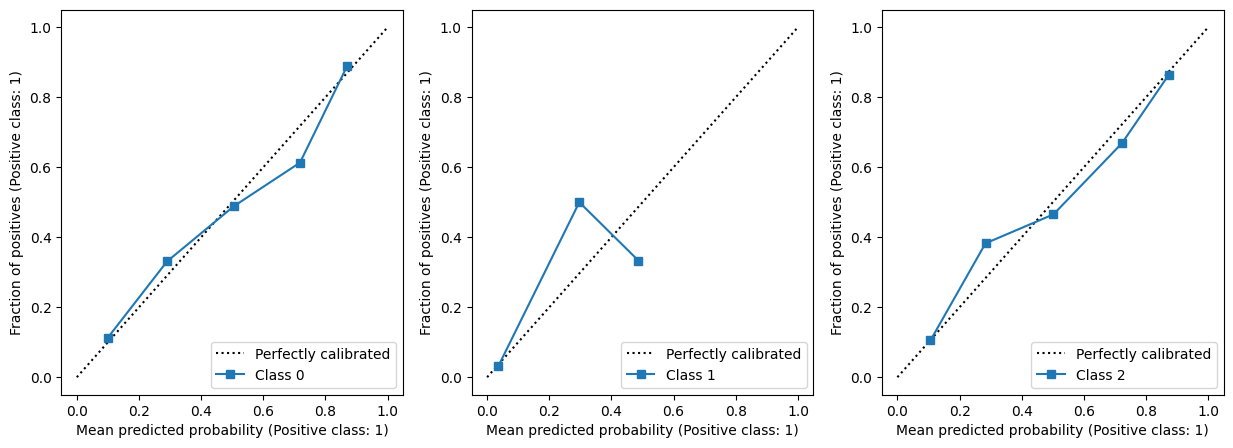

In [55]:
y_val_pred = svc_pipe.predict_proba(X_val)

fig, ax = plt.subplots(1, 3, figsize=[15, 5])
for i in range(0, 3):
    CalibrationDisplay.from_predictions(y_val.map({0: int(i == 0), 1: int(i == 1), 2: int(i == 2)}), y_val_pred[:, i], name=f"Class {i}", ax=ax[i])

In [56]:
if (data_p / "final_svc.calib.pkz").exists():
    svc_pipe_calib = joblib.load(data_p / "final_svc.calib.pkz")
else:
    svc_pipe_calib = CalibratedClassifierCV(svc_pipe, cv=cv, method="sigmoid").fit(X_train, y_train)

log_loss(y_val, svc_pipe_calib.predict_proba(X_val))

0.5566126515909455

In [57]:
print(classification_report(y_val, svc_pipe_calib.predict(X_val)))

              precision    recall  f1-score   support

           0       0.82      0.90      0.86       993
           1       0.00      0.00      0.00        55
           2       0.74      0.68      0.71       533

    accuracy                           0.80      1581
   macro avg       0.52      0.53      0.52      1581
weighted avg       0.77      0.80      0.78      1581



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


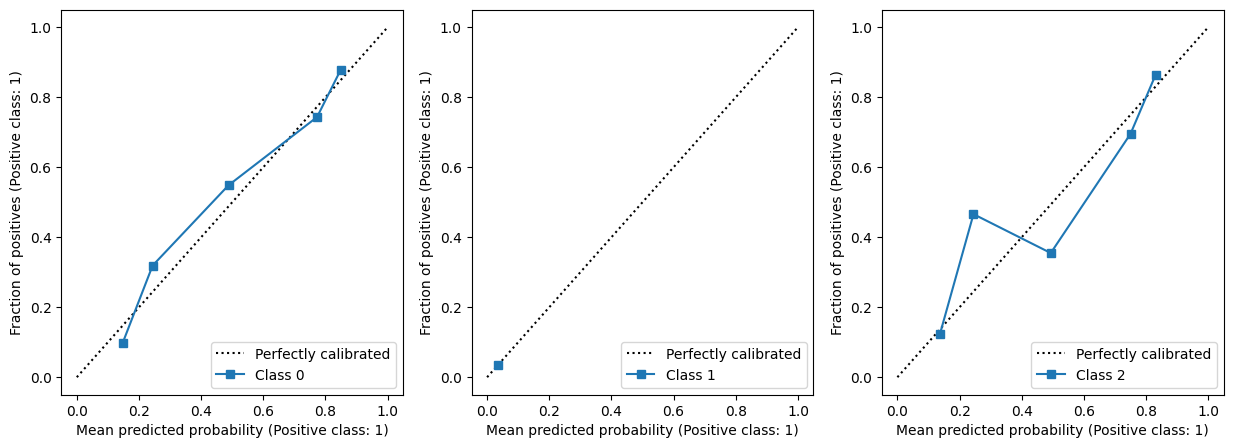

In [58]:
y_val_pred = svc_pipe_calib.predict_proba(X_val)

fig, ax = plt.subplots(1, 3, figsize=[15, 5])
for i in range(0, 3):
    CalibrationDisplay.from_predictions(y_val.map({0: int(i == 0), 1: int(i == 1), 2: int(i == 2)}), y_val_pred[:, i], name=f"Class {i}", ax=ax[i])

# VotingClassifier

In [86]:
def objective(trial):
    w1 = trial.suggest_float("weight_svc", 1e-8, 1.0, log=True)
    w2 = trial.suggest_float("weight_lgb", 1e-8, 2.0)
    w3 = trial.suggest_float("weight_xgb", 1e-8, 2.0)

    xgb_pred = optimised_xgb_pipe.predict_proba(X_val)
    lgb_pred = final_lgb_pipe.predict_proba(X_val, verbose=-1)
    svc_pred = svc_pipe.predict_proba(X_val)

    vote_pred = np.sum([w3*xgb_pred, w2*lgb_pred, w1*svc_pred], axis=0)
    vote_pred /= np.sum(vote_pred, axis=1)[:, None]

    return -log_loss(y_val, vote_pred, sample_weight=y_val.map({0: 1, 1: 2, 2: 1}))

if (data_p / "final_vote.2.pkz").exists():
    study = joblib.load(data_p / "final_vote.2.pkz")
else:
    study = opt.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=1800)
    joblib.dump(study, data_p / "final_vote.2.pkz", compress=9)

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-01-01 11:42:54,261] A new study created in memory with name: no-name-96ad2eb3-ba8c-4458-8004-e76a53b60130
[I 2024-01-01 11:42:55,905] Trial 0 finished with value: -0.4960118751353919 and parameters: {'weight_svc': 0.00025892871920846867, 'weight_lgb': 1.9731588105187838, 'weight_xgb': 1.9030607914169637}. Best is trial 0 with value: -0.4960118751353919.
[I 2024-01-01 11:42:58,371] Trial 1 finished with value: -0.49777905367768915 and parameters: {'weight_svc': 0.1020619500183156, 'weight_lgb': 0.6123926105500139, 'weight_xgb': 1.1293547639843349}. Best is trial 0 with value: -0.4960118751353919.
[I 2024-01-01 11:43:00,680] Trial 2 finished with value: -0.5010377157495209 and parameters: {'weight_svc': 2.039305236937947e-07, 'weight_lgb': 0.24420565024514998, 'weight_xgb': 1.667018793799163}. Best is trial 0 with value: -0.4960118751353919.
[I 2024-01-01 11:43:01,699] Trial 3 finished with value: -0.4954600802599245 and parameters: {'weight_svc': 1.4541806663410976e-06, 'weight_

Number of finished trials:  100
Best trial:
  Value: -0.4953504772689143
  Params: 
    weight_svc: 3.69811284308606e-07
    weight_lgb: 1.8050216065731308
    weight_xgb: 0.7519303106096994


In [103]:
w1, w2, w3 = 3.69811284308606e-07, 1.8050216065731308, 0.7519303106096994

xgb_pred = optimised_xgb_pipe.predict_proba(X_val)
lgb_pred = final_lgb_pipe.predict_proba(X_val, verbose=-1)
svc_pred = svc_pipe.predict_proba(X_val)

vote_pred = np.sum([w3*xgb_pred, w2*lgb_pred, w1*svc_pred], axis=0)
vote_pred /= np.sum(vote_pred, axis=1)[:, None]

log_loss(y_val, vote_pred)

0.43519173262115834

In [106]:
pred = np.argmax(vote_pred, axis=1)
print(classification_report(y_val, pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.88       993
           1       0.56      0.18      0.27        55
           2       0.78      0.74      0.76       533

    accuracy                           0.82      1581
   macro avg       0.73      0.61      0.64      1581
weighted avg       0.82      0.82      0.82      1581



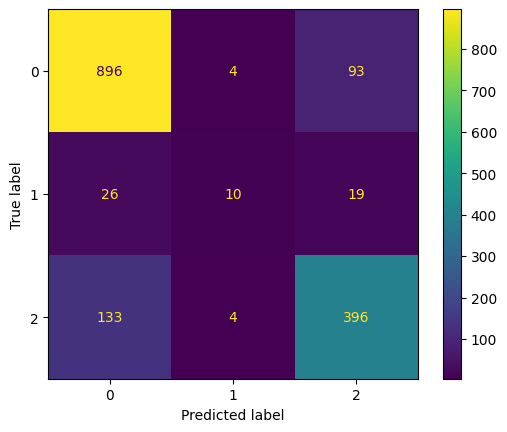

In [107]:
ConfusionMatrixDisplay.from_predictions(y_val, pred)

In [100]:
xgb_pred = optimised_xgb_pipe.predict_proba(test_out.drop(columns="id"))
lgb_pred = final_lgb_pipe.predict_proba(test_out.drop(columns="id"), verbose=-1)
svc_pred = svc_pipe.predict_proba(test_out.drop(columns="id"))

vote_pred = np.sum([w3*xgb_pred, w2*lgb_pred, w1*svc_pred], axis=0)
vote_pred /= np.sum(vote_pred, axis=1)[:, None]

submission = pd.concat([test[["id"]], pd.DataFrame(vote_pred, columns=["Status_C","Status_CL","Status_D"])], axis=1)
submission.to_csv(data_p / "submission.csv", index=False)

submission.describe()

,id,Status_C,Status_CL,Status_D
count,5271.000000,5271.000000,5271.000000,5271.000000
mean,10540.000000,0.626741,0.030683,0.342576
std,1521.750965,0.353164,0.067907,0.345169
min,7905.000000,0.000860,0.000073,0.001795
25%,9222.500000,0.280839,0.003477,0.048315
50%,10540.000000,0.787409,0.009158,0.175998
75%,11857.500000,0.939415,0.027128,0.647301
max,13175.000000,0.995635,0.748574,0.999067
